# Mapping Electrocatalyst Activities across >6000 Conditions Simultaneously



### Peter Defnet
*Up to date as of July 10, 2021*


The goal of this project is to create a simple visualization that maps electrocatalyst activity from an array of electrodes.


The workflow is divided into three parts:

1. Create a blank template fo each electrode position. (ImageJ)


2. Extract light intensity for each location. (ImageJ)


3. Map catalytic activity onto the electrode template. (Python)

## Part 1: Create a Blank Template for each Electrode Position (ImageJ)

We begin by creating binary image of the electrode positions using an ImageJ macro. This will serve as the template for which values are mapped to in Python. It is therefore critical that the product looks uniform and representative of the original array structure.

We start by setting up local variables to enable automatic saving, used later in the script. 'filename_load' is simply the name of the tiff stack (video) as a string, and 'file_extension' is the path where the results will be saved. The specific path for the thresholded image (.tif) and results (.txt) are also defined.

In [31]:
#//Set Saving Parameters and Create Directories

#filename_load = "T2" // This name should match the title of the open video. 
#file_extension = "C:/Users/Peter/Desktop/Github/Spatially Mapping Electrode Response Data using Python & ImageJ/Github Pages Post/Program Output/" + filename_load + "/" // Names the folder to save data into. 

#File.makeDirectory(file_extension) //Creates folder to save data into. 
#Save_threshold = file_extension + "thresh_" + filename_load + ".tif" //Creates name of thresholded image file.
#Save_results = file_extension + "Results_" + filename_load + ".txt" // Creates name of results data file. 

The template is created by first averaging 200 non-light producing frames at the start of the video. The ambient light in the room produces a clear product showing electrode positions. We then invert the averaged image, convert it to 8-bit, and apply a local threshold to make a uniform binary template. Figure 1 displays this process.

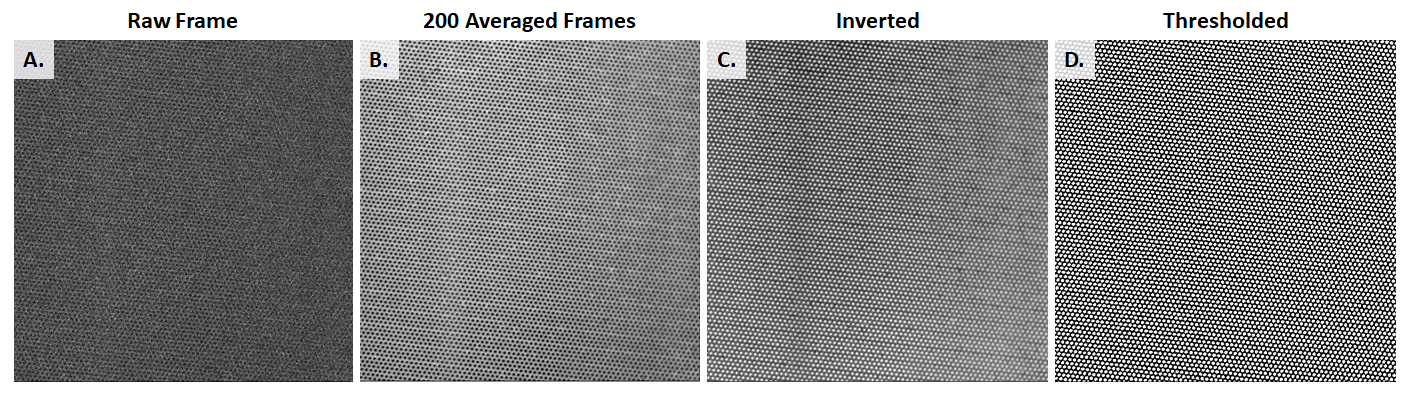

In [18]:
from IPython.display import Image
Image(filename='C:/Users/Peter/Desktop/Github/Spatially Mapping Electrode Response Data using Python & ImageJ/Figure 1.png') 

In [19]:
#// Define Thresholded image by averaging the first 200 blank frames.
#// (Averaging the noise in 200 blank frames uses the ambient light present during recording to reveal electrode locations)

#selectWindow(filename_load + ".tif"); // Select window of video.

#run("Duplicate...", "duplicate range=1-200"); // Duplicate frames 1-200
#run("Z Project...", "projection=[Average Intensity]"); // Find Average Intensity of these first 200 frames. 
#run("Invert"); // Invert the colors of Avg
#run("8-bit"); // Convert to 8-bit image
#run("Auto Local Threshold", "method=Median radius=5 parameter_1=0 parameter_2=0 white"); //Apply local threshold, such that the electrode locations and background are binarized.

Sometimes the generated template contains multiple connected electrodes. To resolve this issue, we apply a series of "watershed" and "fill holes" commands to imrpove the template's uniformity. The thresholded image is then saved and later used in Python.


In [20]:
#run("Options...", "iterations=1 count=1 black do=Nothing"); //white objects, black background
#run("Watershed"); //Separate the electrodes connected by corners
#run("Fill Holes"); // Fill holes in electrodes, making for a more well-rounded shape. 
#run("Watershed"); // Again, separate the electrodes connected by corners
#saveAs("Tiff", Save_threshold); //Save thresholded image. The thresholded image serves as a blank canvas to map values onto in         the .py program. 


## Part 2: Extract Light Intensity for Each Location. (ImageJ)


We then identify each unique electrode position (ROI) in the template, and extract each electrode's intensity data for the video. Each channel is assigned a unique identifier relating to its original position in the image. The data is appended to a single large table, and is saved for later analysis in Python. 

In [21]:
#//Obtain data from each ROI in thresholded image.

#run("Analyze Particles...", "size=5-Infinity display clear add"); // Identify regions with a size of >5 pixels. Anything small is considered noise. 
#run("Set Measurements...", "mean centroid area_fraction stack display redirect=None decimal=3"); // Set which values to     extract in results file. 
#roiManager("Associate", "false"); // Explicitly set parameters of ROI manager. 
#roiManager("Centered", "false"); // Explicitly set parameters of ROI manager. 
#roiManager("UseNames", "true"); // Explicitly set parameters of ROI manager. 
#selectWindow(filename_load + ".tif"); // Select video.
#roiManager("multi-measure measure_all"); // Extract selected values from each location identified in ROI manager. 
#saveAs("Results", Save_results); // Save results as a .txt file. The intensity data will be processed in Python to summarize            each electrode's individual response. 

#close(filename_load);
#close("thresh_" + filename_load);
#selectWindow("Results"); 
#run("Close" );

## Part 3: Map catalytic activity onto the electrode template. (Python)

In Python, we import both the thresholded image, and results table from the folders from which they were saved in Imagej. Note that 'filename_load' and 'file_extension' are defined identically as they were in the Imagej script, and represent the only inputs for this program.

In [22]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from skimage import io, measure
import warnings
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600 #Changes DPI of in-line figures.


"""Load and Clean Data""" 

#Load Directory. 
filename_load = "T2" #number on thresh, results files. 
file_extension = "C:/Users/Peter/Desktop/Github/Spatially Mapping Electrode Response Data using Python & ImageJ/Github Pages Post/Program Output/"
save_folder = file_extension + str(filename_load)

#Load Thresholded Image
img = io.imread(file_extension + str(filename_load) + '/' + 'thresh_' + str(filename_load) + '.tif')

#Import ROI results df #Saved results in imagej from ROI manager. 
res = pd.read_csv(file_extension + str(filename_load) + '/' + 'Results_' + str(filename_load) + '.txt', sep = '\t')
res.columns = ['Count', 'Label', 'Mean', 'X', 'Y', '%Area', 'Slice']

Some minor data cleaning is performed to create a subset containing only the ROI number and (x,y) coordinates for the imagej regions.

In [23]:
#Create ROI Column
res['ROI'] = res['Label'].apply(lambda x: (x.split(":",2)[1]).split("-",1)[0]) #Select ROI # from Label. #Splitting on ":" makes sure this should always work.
res['ROI'] = res['ROI'].astype(int) #Convert ROI to integer


#df to extract Intensity-Frame profiles from. 
res_sort = res.sort_values(["ROI", "Slice"], ascending = (True, True)) #Sort by ROI, Slice#. 
res_sort.reset_index(drop=True, inplace=True)



#subset df to pull unique ROI #'s and xy coords
coords = res.drop_duplicates(['ROI'])

df = coords[['ROI', 'X', 'Y']] 
df.loc[:,'X'] = np.round(df.loc[:,'X'], decimals=0)
df.loc[:,'Y'] = np.round(df.loc[:,'Y'], decimals=0)


C:\Users\Peter\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Next, the thresholded image, “img” is ‘labeled’ using the skimage.measure function. This assigns each isolated whitespace in the image with a unique value (for each electrode 1-~6000).

It is important to note that the ROI labels from Imagej (and corresponding data) may be different values than the labels assigned by Python's "measure.label()". We must therefore reassign the Python labels to match the Imagej ROI labels to ensure that the Imagej intensity data is mapped to the correct electrode.

The general strategy used is to extract the mean (x,y) coordinate for each ROI in Imagej, and determine which python-assigned ROI label has x,y coordinates that overlap with this value. The label of the overlapping python region is then reassigned to the value of the corresponding Imagej region.

Note that an offset of 10,000 is added to the reassigned label to prevent bugs associated with reassigning a single ROI's value multiple times in the same loop. The offset is removed once all the values have been reassigned. I also implemented an internal “check” to output the number of non-matching regions and screen for errors. See the comments for a line by line description of the code.

In [24]:
def label_ROI(df):


    #Label connected regions > 0 
    img_label = measure.label(img, background=0) 
    
    
    #Change img_label number to accurate ROI number from Imagej
    
    img_label_mod = img_label.copy()
    check = []
    non_match_x=[]
    non_match_y=[]
    non_match_roi=[]
    for i in range(len(df)):
        
        roi = df.iloc[i,0]
        x = int(df.iloc[i,1]) - 1 # -1 to account for 0 index.  0-511.  Not 1-512.
        y = int(df.iloc[i,2]) - 1 # -1 to account for 0 index. 
        
        if img_label[y,x] > 0 : #if ROI coordinate matches with thresholded image
            
            img_val = img_label[y,x] #Find img_label # that ROI overalps with
            
            #Change img_label value (thresholded image) to ROI #
            img_label_mod[img_label_mod == img_val] = roi + 10000 # roi ; add offset to eliminate possibility that this values is mistakenly reassigned later in loop. 
            
        else:
            non_match_roi.append(roi) #non-matching ROI
            non_match_x.append(x) #non-matching ROI
            non_match_y.append(y) #non-matching ROI
    
            
    img_label_mod = img_label_mod - 10000 #Return ROI values to normal.
    img_label_mod[img_label_mod < 0] = 0 #turn all non-matching values to 0. 
    
    print('Number of non-matching ROI centroids: ' + str(check.count(0))) # Number of non-matching ROI centroids with img_labels. 
    


    return img_label, img_label_mod

In [25]:
#Run 'label_ROI()'
img_label, img_label_mod = label_ROI(df)

Number of non-matching ROI centroids: 0


Lastly, I plot the before and after labeled image with imshow() to verify that the relabeled values create an image similar to the original.

In [26]:
"""Plot Label #'s on thresholded image."""
 

def plot_ROI_image(img_label, title = "Python Auto-Labled Image", save = "/Python-Labeled Thresholded Image.png"):
    
    
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img_label)
    
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(28)
    
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()
    plt.show()  


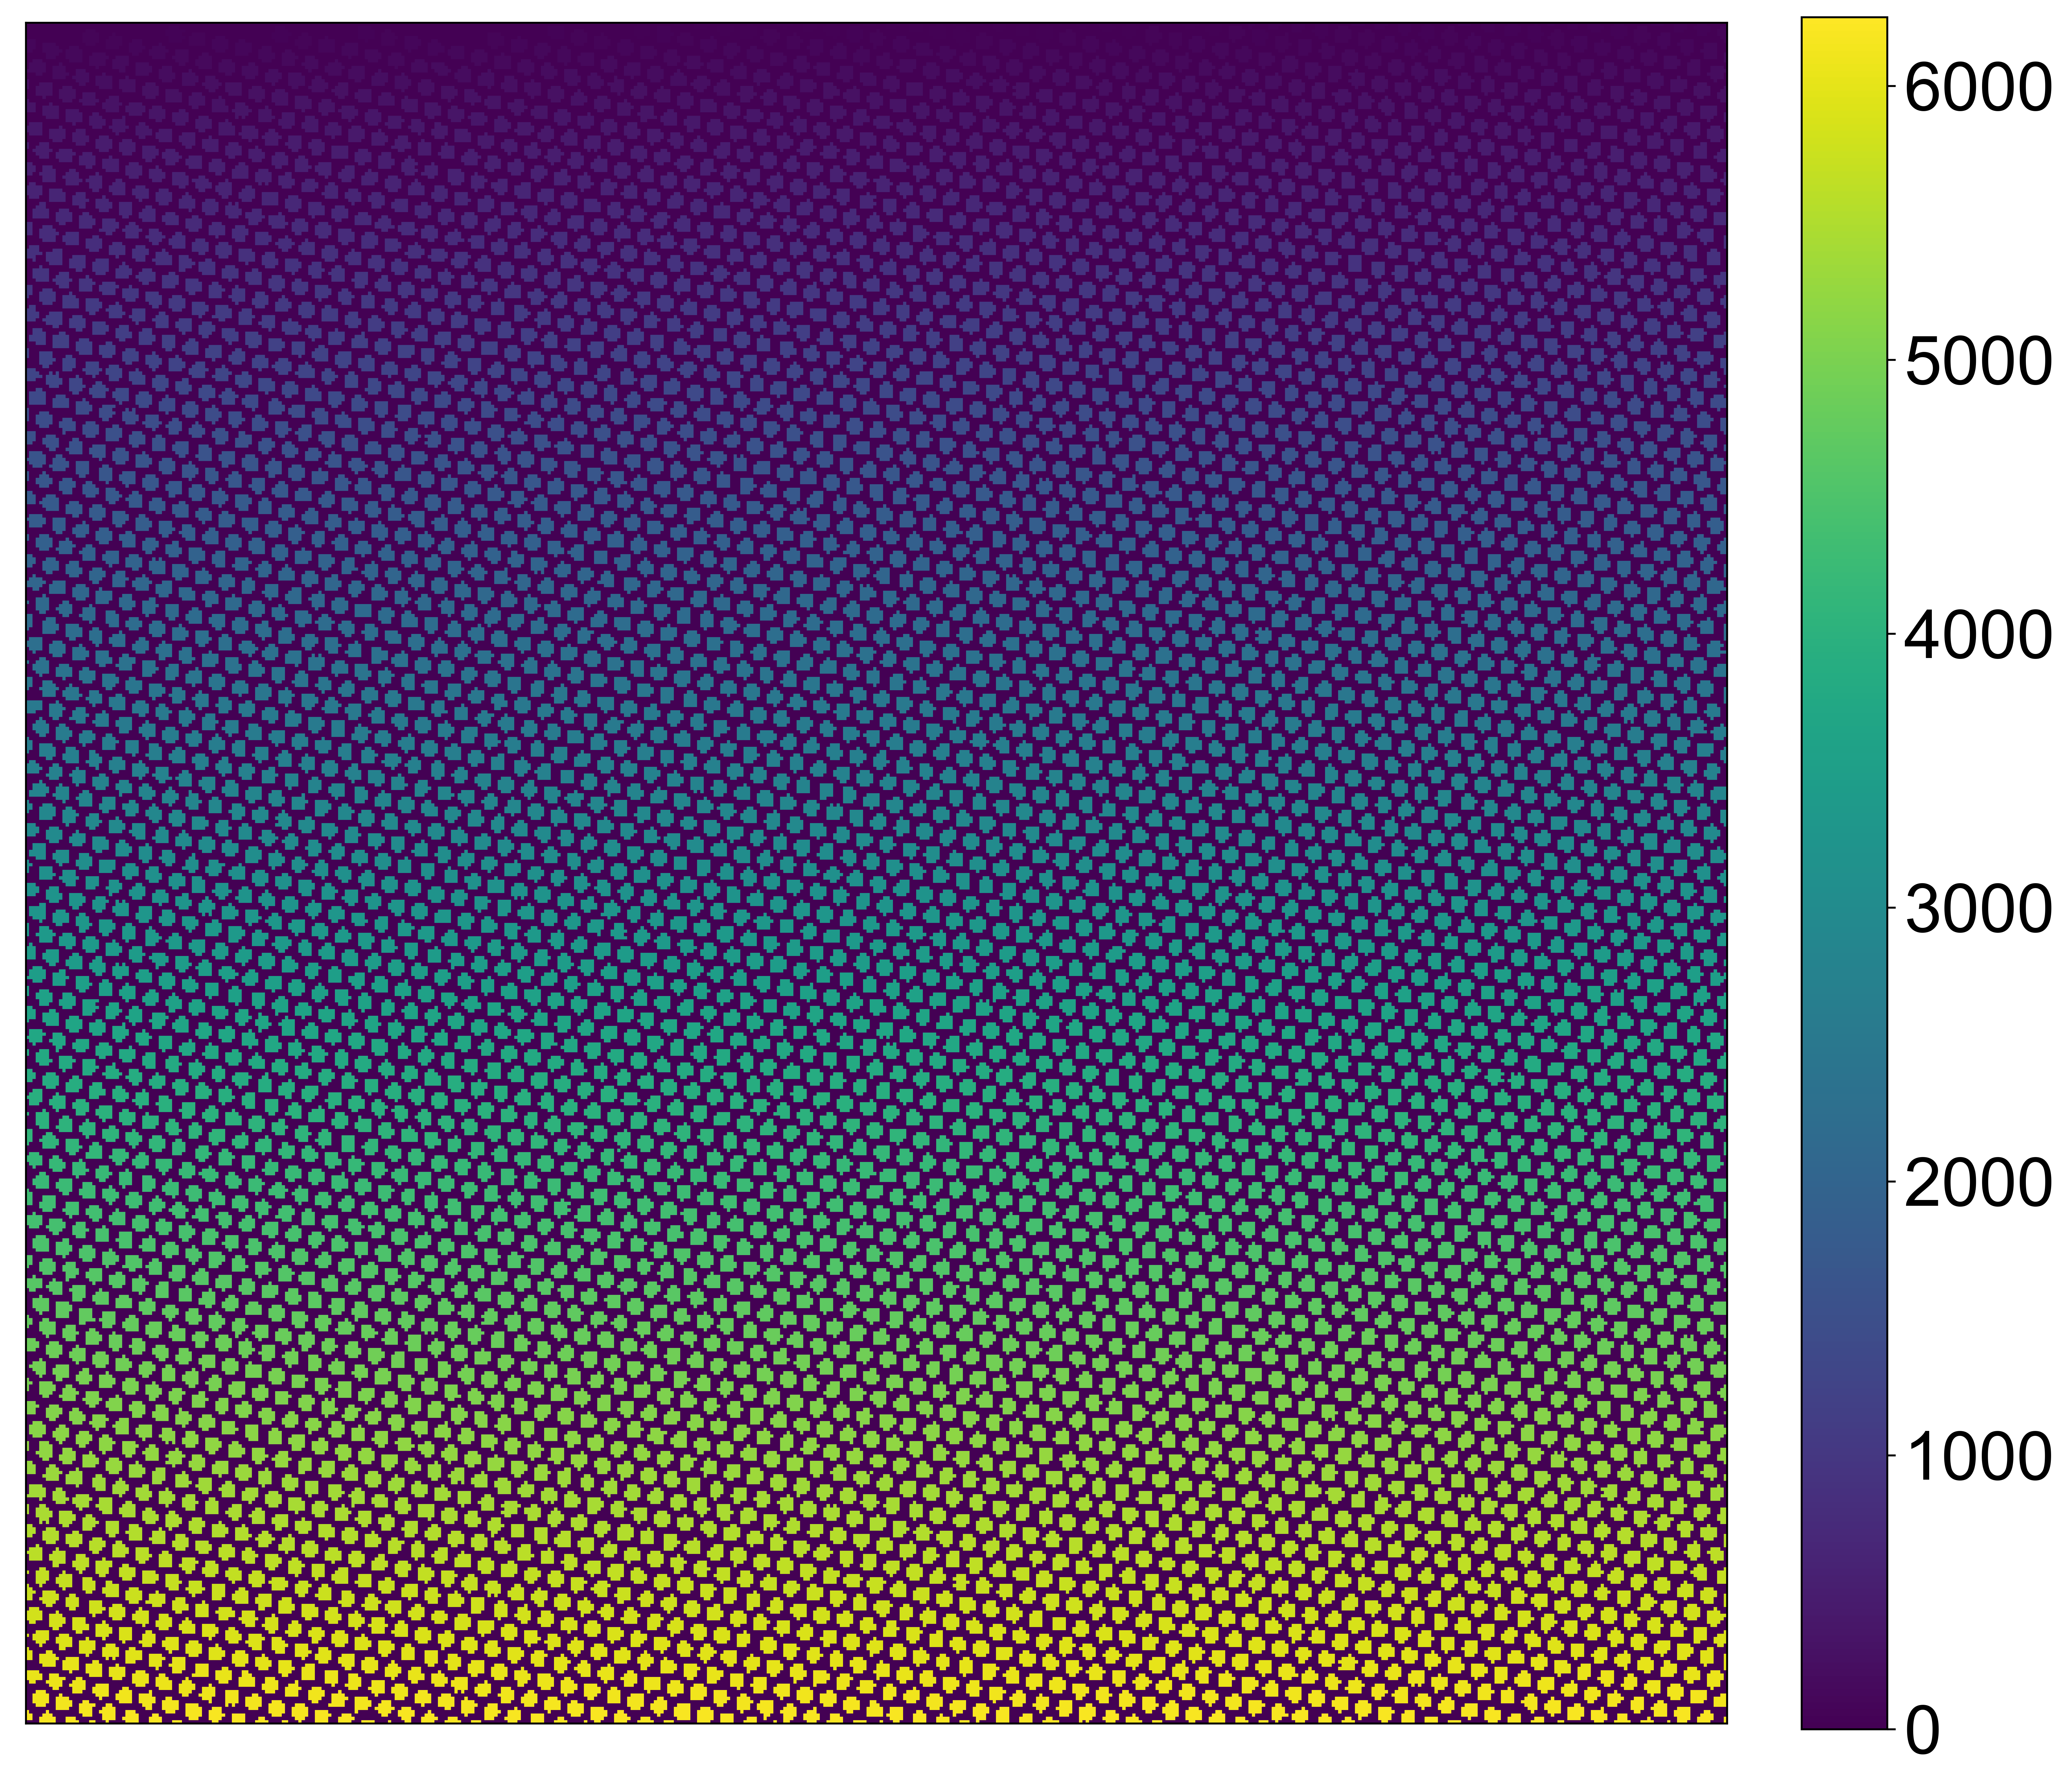

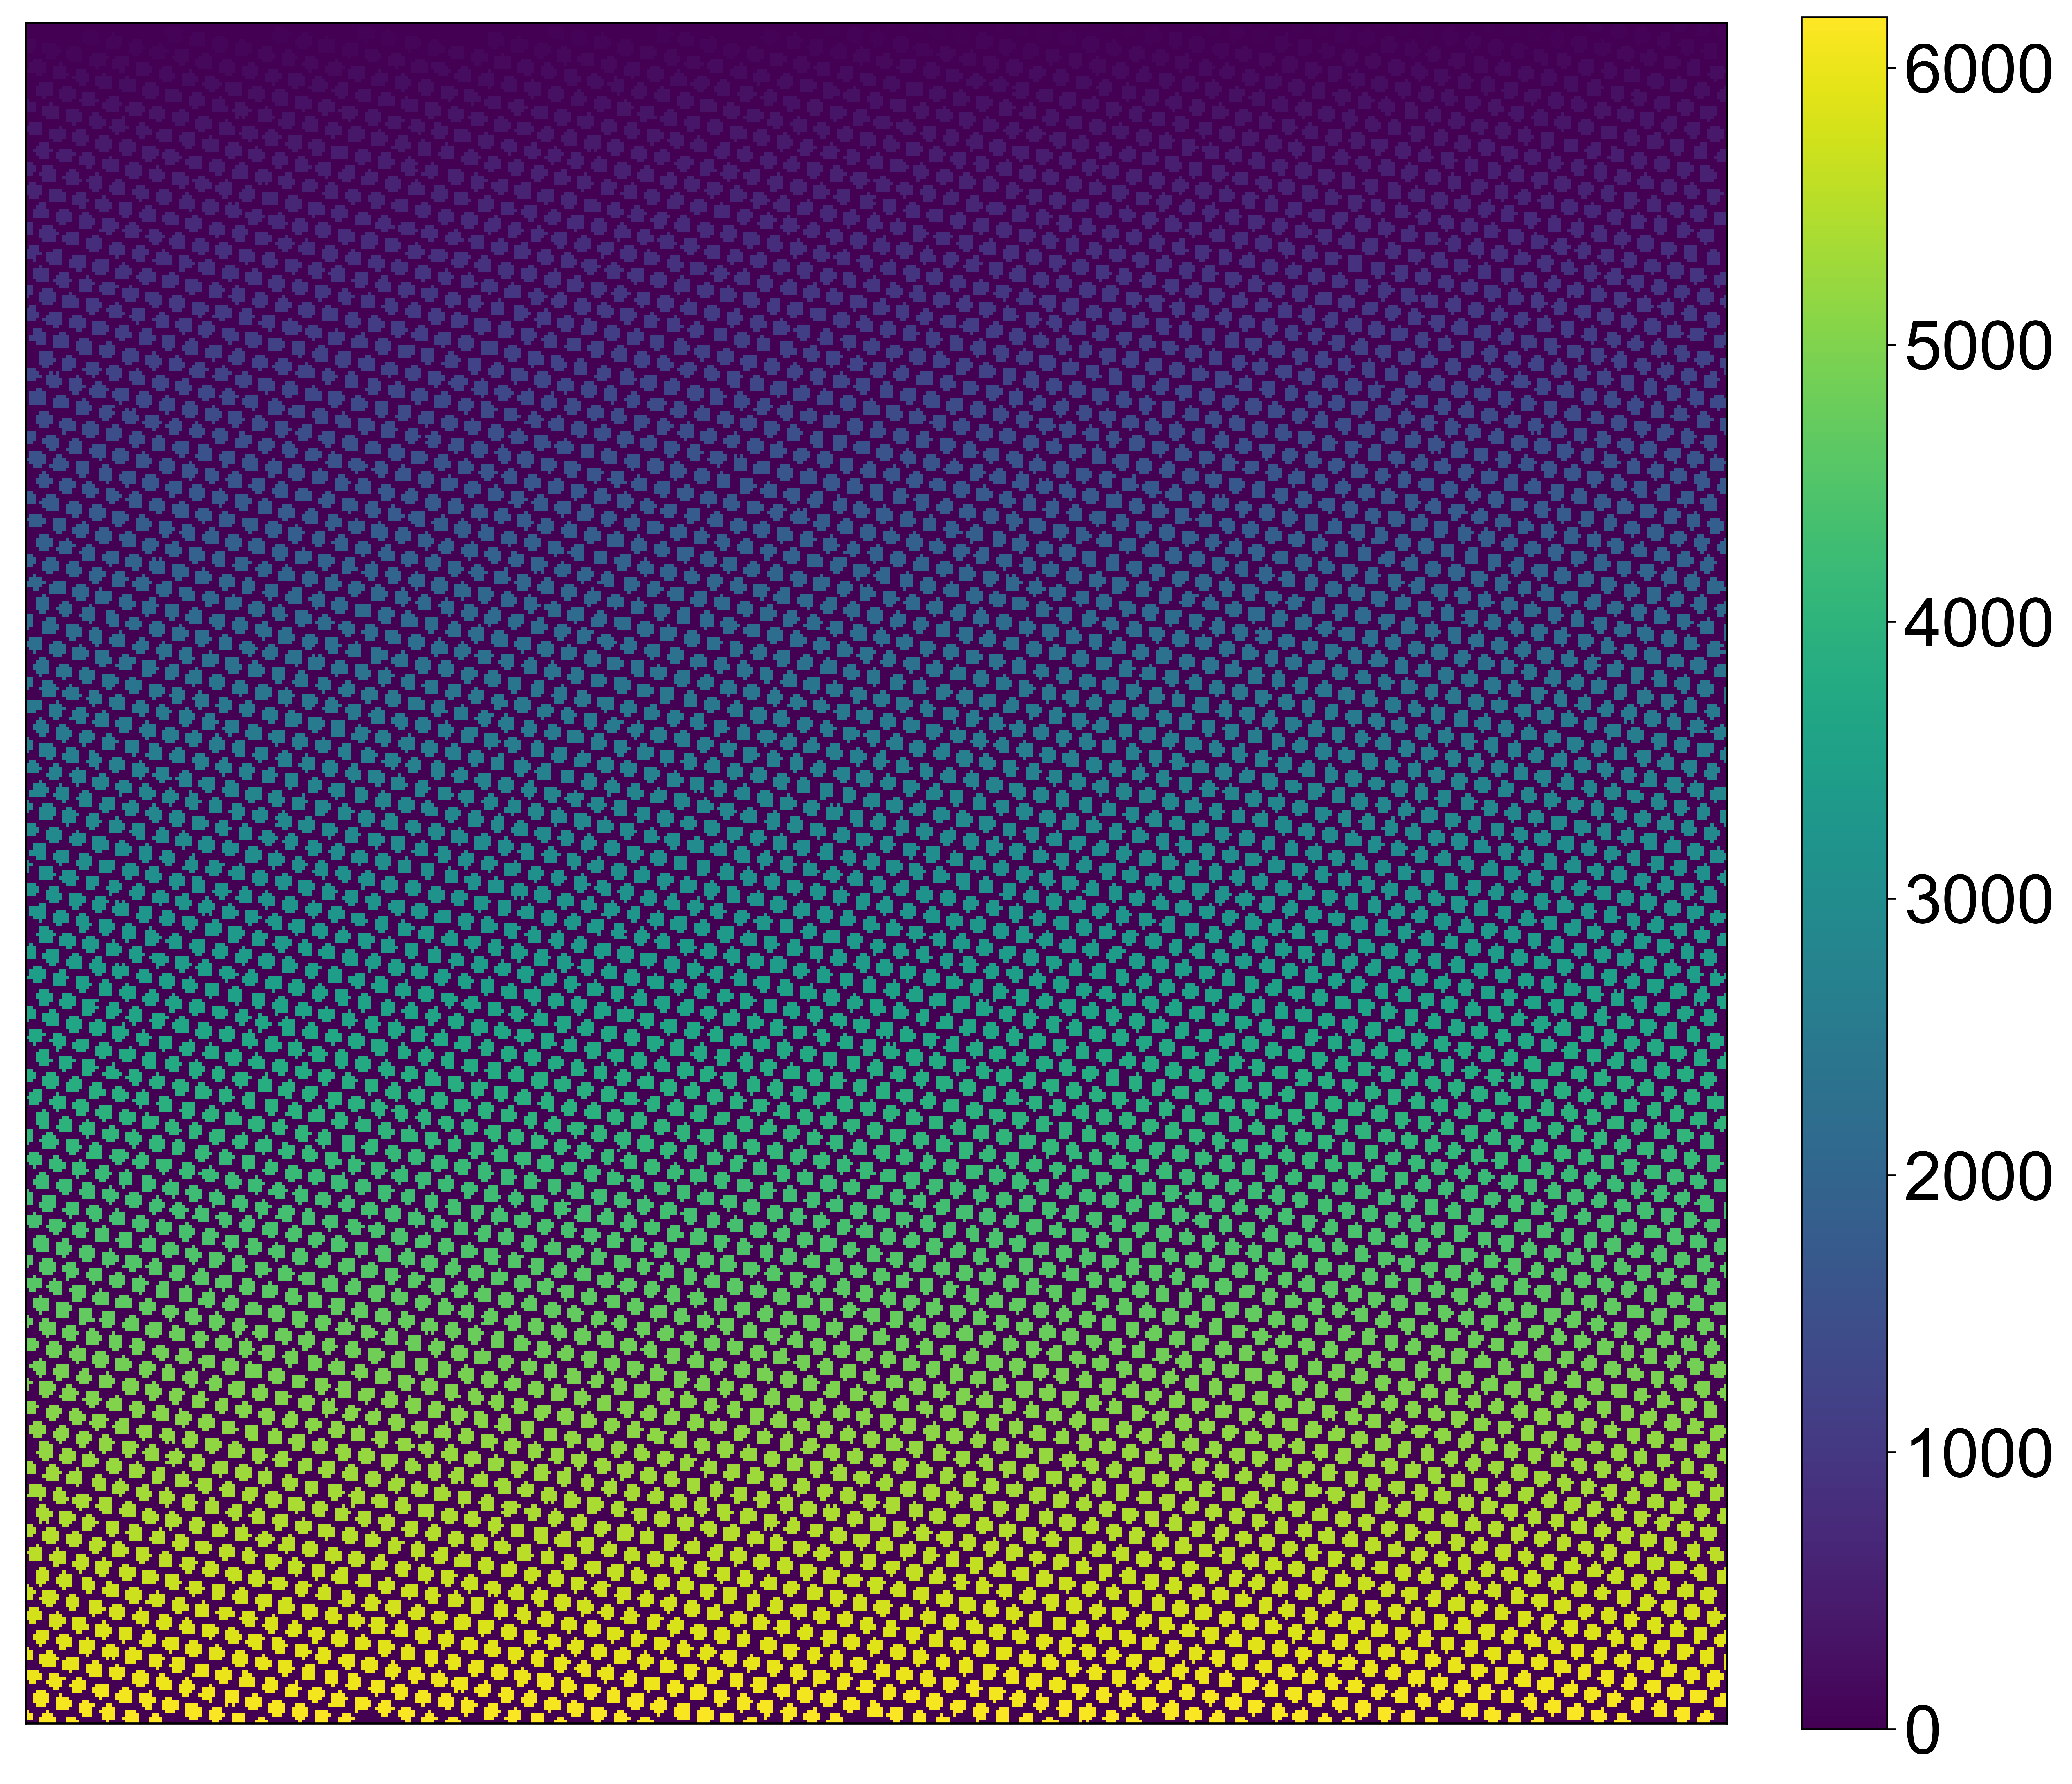

In [27]:
#Plot Labeling before running "label_ROI()"
plot_ROI_image(img_label, title = "Python Auto-Labled Image", save = "/Python-Labeled Thresholded Image.png")


#Plot Results of "label_ROI()"
plot_ROI_image(img_label_mod, title = 'ROI Labeled Image', save = '/Frame # where Intensity larger.png')


From here, we know that the ROI values in ‘img_label_mod’ match the ROI values from the Imagej results data, saved in ‘df_sort’. Therefore any analysis done on the data can be mapped back to its original position.

Frankly, the results before and after modifying the ROI labels look the same. Though now we have the certainty that they indeed are the same!

In [28]:
'''Create df's used for analysis functions'''

df = res_sort[['Mean', 'Slice', 'ROI']]
df_sort = df.sort_values(['ROI', 'Slice'], ascending = (True, True))

## Example Application of Mapping Electrode Data: Screening Electrocatalyst Activity

Next we analyze each trace, and identify the frame in which the light turns on. This value is converted to potential (the metric used for electrocatalysis), and subsequently mapped to is respective position on the template. See the below comments for a walkthrough of the code.

In [29]:
'''Map which ROI's turn on at thresholded Intensity + Plot Histogram of results'''

def map_threshold(df_sort, threshold):
    
    #threshold = 350
    '''Input dataframe with columns labeled 'ROI', 'Mean', 'Slice' 
    Output df with rows as ROI, Mean, Slice where threshold value occurs in each ROI
    Note that plots are NOT auto-saved'''
        
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns 

    
    
    '''Determine thresholded frame for each ROI'''
    total_roi = df_sort.ROI.max()
    save = pd.DataFrame()
    for i in range(1, (total_roi + 1)): #6000+ ROI's
        
        current_roi = df_sort[df_sort['ROI'] == i] # identify single ROI
        mean_col = current_roi.Mean #select only intensity column.
        thresholded_frame = pd.DataFrame(current_roi.iloc[np.argmax(mean_col > threshold)]).T #np.argmax() finds the first instance where condition is true. 
        
        save = pd.concat([save, thresholded_frame], axis = 0) #Output with thresholded info. #Slice info, ROI, intensity
    
    save.reset_index(inplace=True, drop=True) # 'save' contans a df of frames where threshold is surpassed for all ROI's. 
    
    
    
    map_threshold_slice = img_label_mod.copy()
    for i in range(1, int(np.max(save.ROI))+1): #Changes value of img_label_mod to slice # of threshold. 
        current_row = save.loc[save['ROI'] == i]
        
        roi_num = int(current_row['ROI'][i-1]) #since index increments, and is 1 behind iterator. 
        slice_num = int(current_row['Slice'][i-1]) 
        
        #map slice
        map_threshold_slice = np.where(map_threshold_slice == roi_num, slice_num + 10000, map_threshold_slice) #Where True, yield x, otherwise yield y. 
        
    map_threshold_slice = map_threshold_slice - 10000 #Introduced offset to avoid re-labeling same ROI multiple times. 
    
    

    #Remove 0's, 1's from 'save'
    save['Slice'] = save['Slice'].replace([0 ,1], np.mean(save.Slice))
     
    
    
    
    #Convert Slice # to mV.
    #200 mV/s * 0.032 s/ Frame = 6.4 mV / Frame
    #3.2 mV / Frame = 100 mV per s
    map_threshold_mV = map_threshold_slice * (3.2)
    save['mv'] = save.Slice.apply(lambda x: x * (3.2)) 
    

    #Custom color map
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    

    colors1 = plt.cm.bone(np.linspace(0., 1, 1))
    colors2 = plt.cm.jet_r(np.linspace(0, 1, 255))
    
    # combine them and build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    


    range_min = 1500
    range_max = 3000
    
    #Plot Histogram 
    with warnings.catch_warnings(): #Ignore warnings given by deprecation of sns.distplot()
        warnings.simplefilter("ignore")
    
        #Map Threshold mV  #Want base of colorbar to be black or white, but not red. 
        plt.figure(figsize=(12,12))
        plt.rcParams['font.family'] = "Arial"

       
        plt.imshow(map_threshold_mV, cmap= mymap, vmin = save.mv.min()-30) #Scales so that colorbar min = first threshold - 30  #Works best for 
        cbar = plt.colorbar(fraction=0.046, pad=0.04)
        

        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(26)
            
        plt.xticks(fontsize = 28)
        plt.yticks(fontsize = 28)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.tight_layout()
        plt.show()   
    

        #Plot Histogram, KDE of Potential where intensity > threshold.
        sns.kdeplot(save.mv, shade=True)
        plt.xlabel('Potential (mV)', fontsize = 12, labelpad = 10)
        plt.ylabel('Density', fontsize = 12, labelpad = 10)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.xlim(range_min, range_max)
        plt.ylim(0, 0.015)
        plt.tight_layout()
        plt.show()


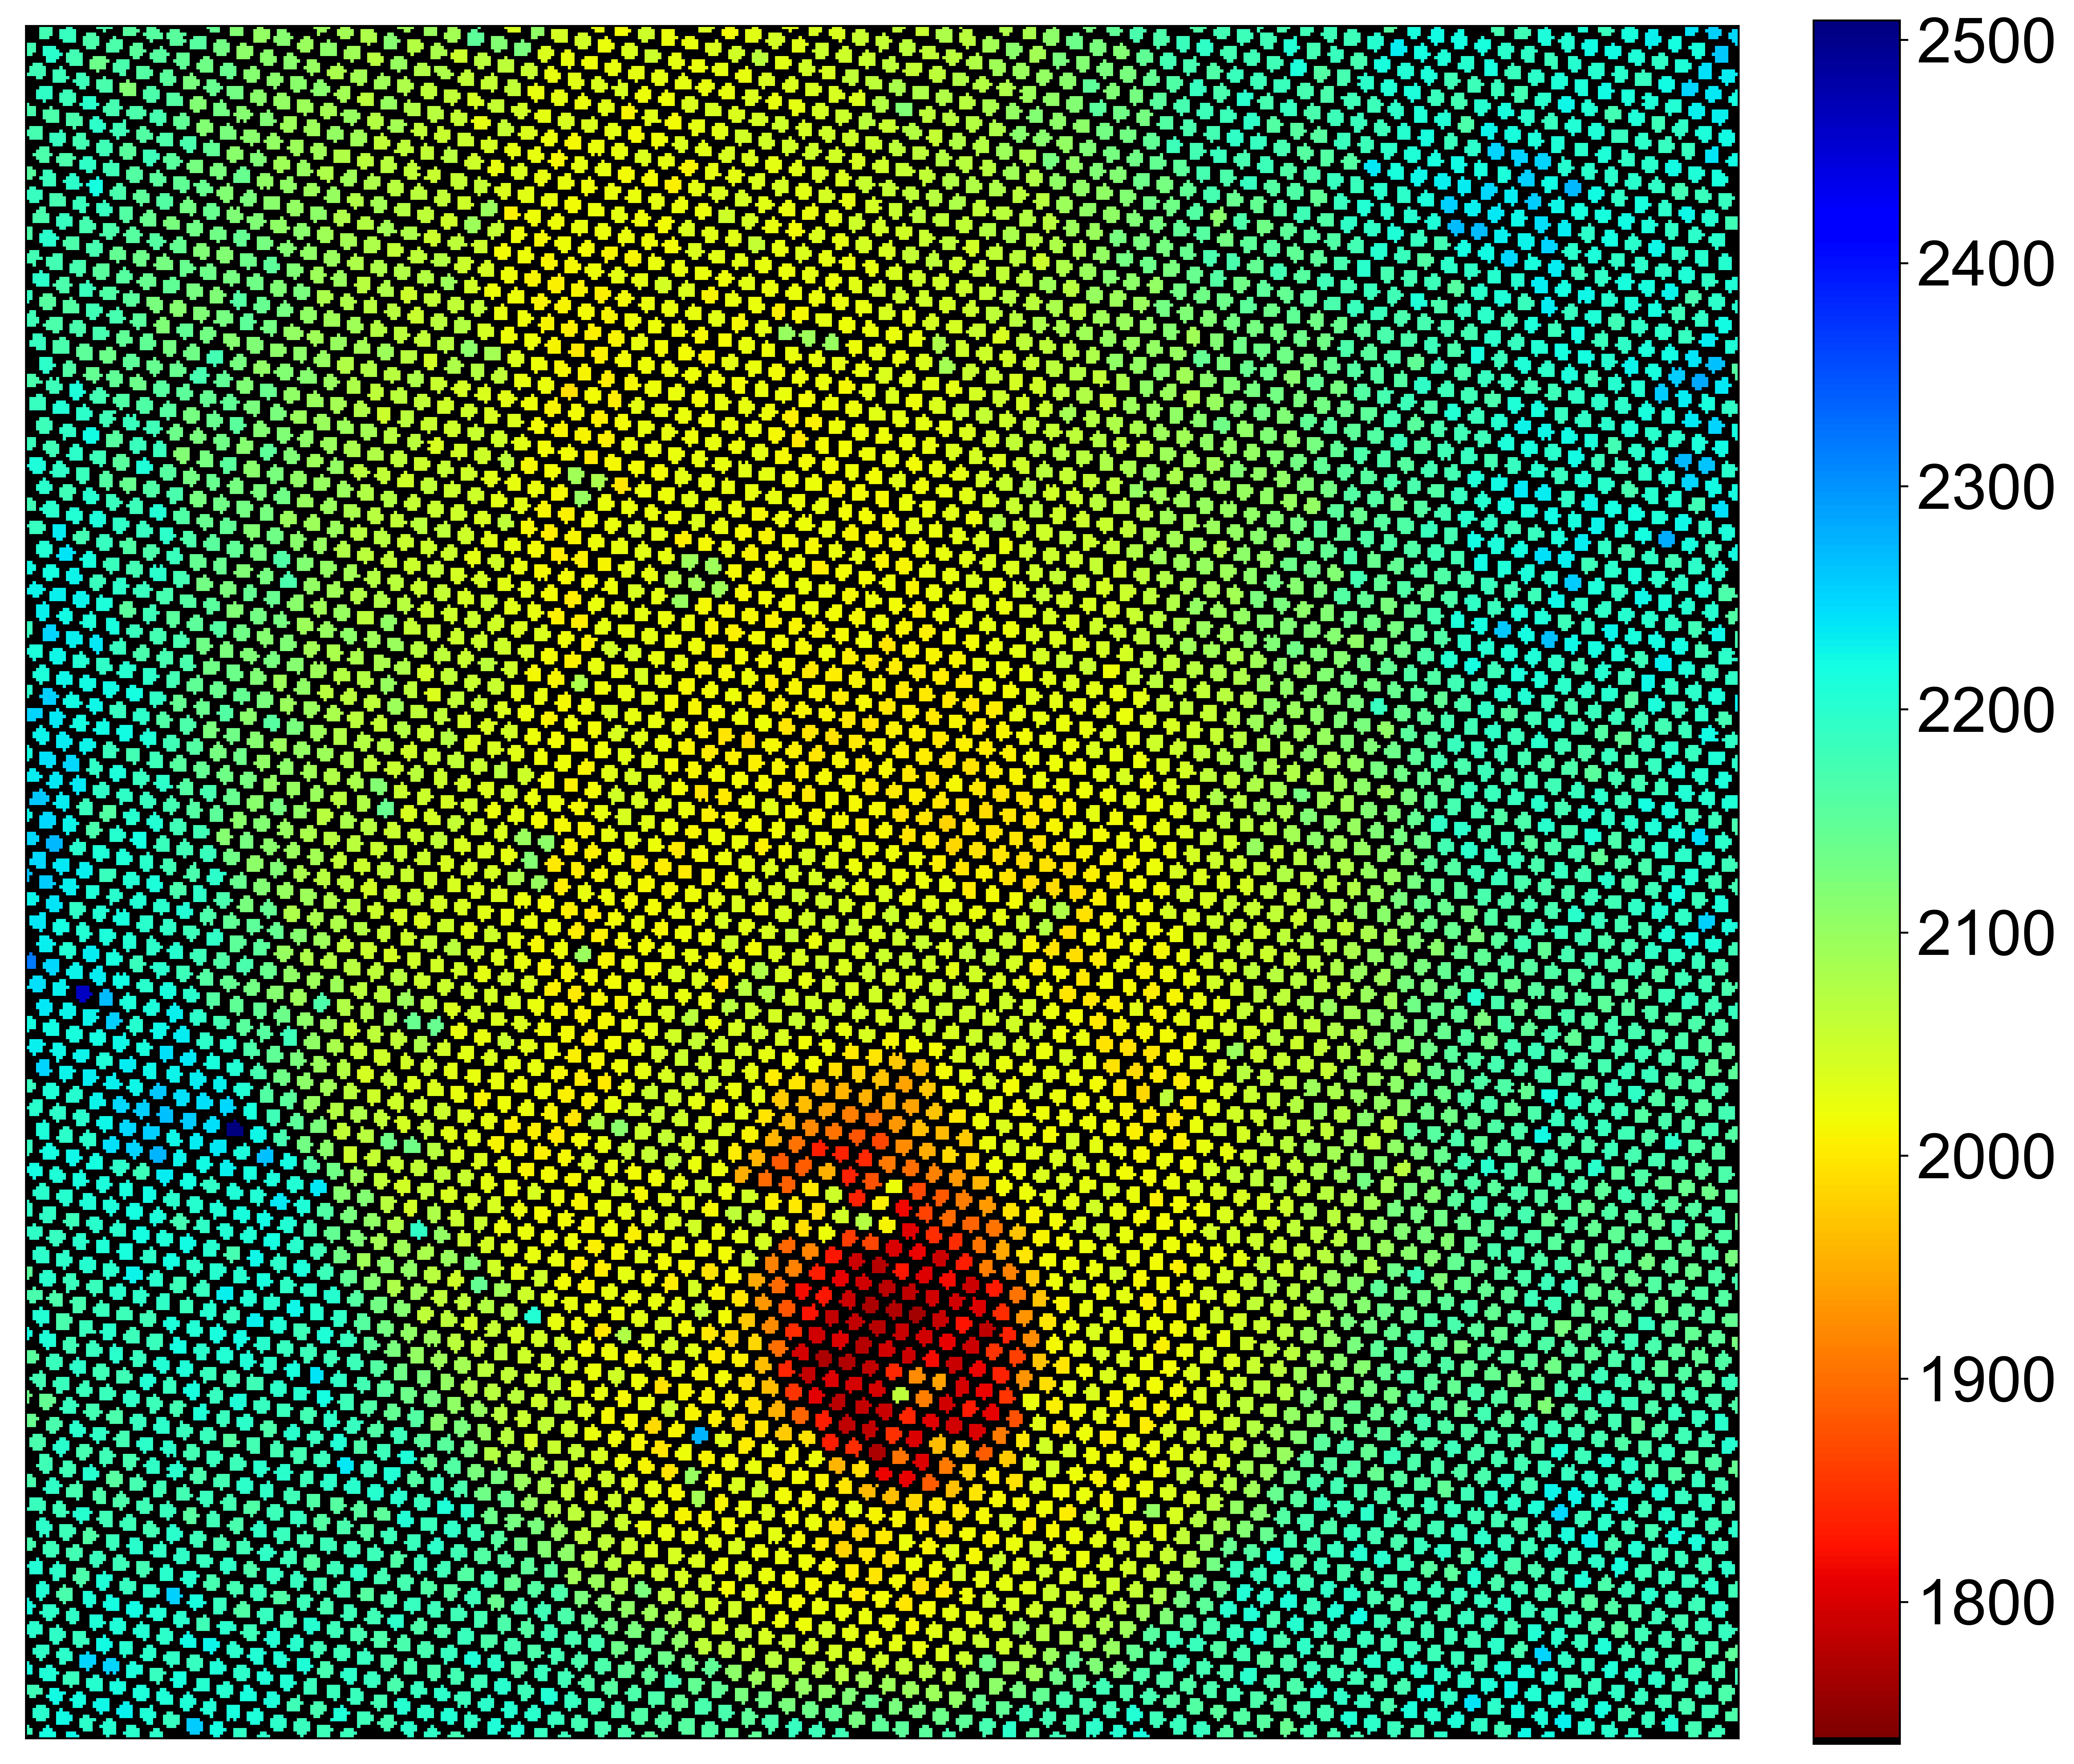

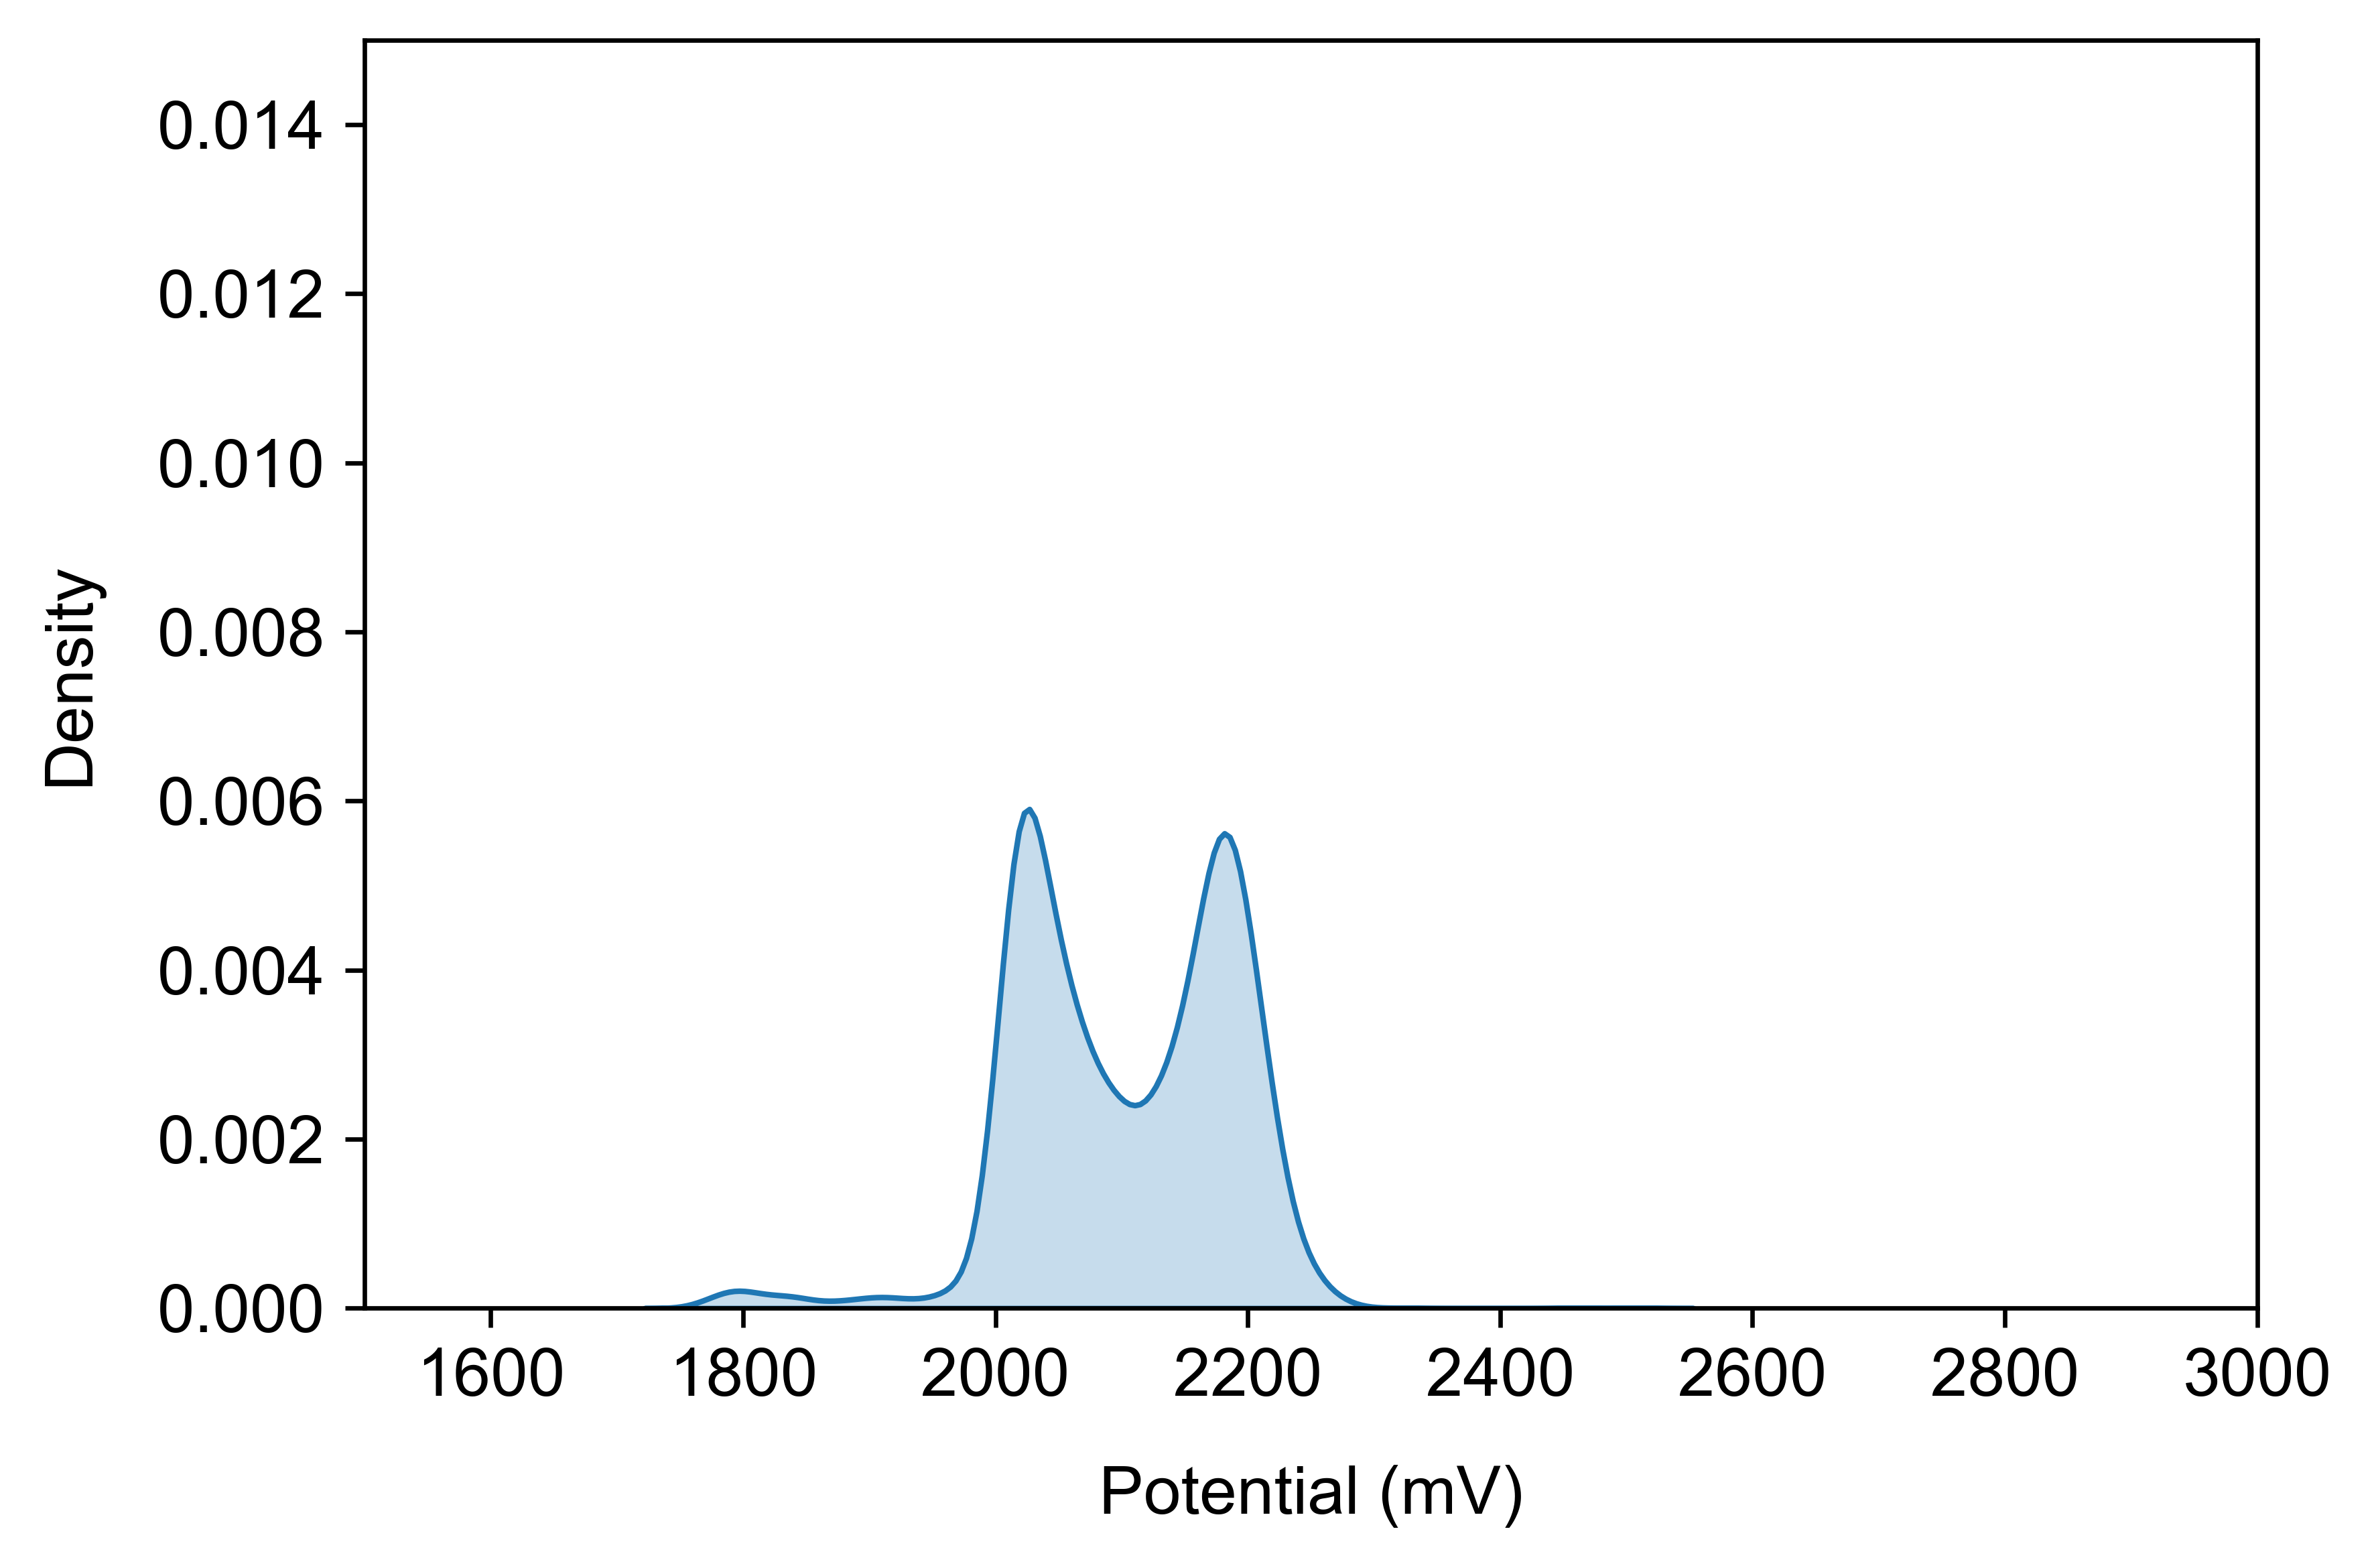

In [30]:
#Output Plots:
map_threshold(df_sort, 180) # intensity 

The mapped output clearly shows regions with higher activity than others! Indeed further experimentation can be done to determine the elemental composition at the active red-electrode positions. 

Lastly, I plot the KDE of these values for a more quantitative interpretation. 

## Conclusion: 
The described pipeline is quite powerful for interpreting results from large electrode arrays. It produces simple visualizations from data that would otherwise be challenging to interpret manually. I anticipate derivatives of this pipeline being reused for other array-based applications that my Ph.D. lab takes on in the future.